# BERT-Based Sentiment Analysis on IMDB Dataset
## Fine-Tuning Pre-trained Models for Text Classification
**Author:** Marco Gonzalez

## Overview

This notebook demonstrates fine-tuning a pre-trained BERT model for sentiment analysis on the IMDB movie review dataset. The implementation covers text preprocessing, model training, evaluation, and prediction phases using the Transformers library.

**Key Components:**
- Text preprocessing with BERT tokenizer
- Fine-tuning pre-trained BERT model
- Model evaluation with comprehensive metrics
- Sentiment prediction on sample reviews


## Installation Instructions

Before running this notebook, install the required dependencies:

```bash
pip install -r requirements.txt
```

**Note:** If you encounter Keras compatibility issues, run:
```bash
pip install tf-keras
```

**Required packages:** transformers, torch, datasets, scikit-learn, pandas, numpy


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    TrainingArguments, Trainer
)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("BERT Sentiment Analysis: IMDB Movie Reviews")
print("=" * 50)
print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


2025-09-22 15:25:11.124938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 15:25:11.164488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 15:25:12.100814: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


BERT Sentiment Analysis: IMDB Movie Reviews
Libraries imported successfully
PyTorch version: 2.8.0+cu128
CUDA available: False


In [2]:
# Load the IMDB dataset
print("Loading IMDB dataset...")
df = pd.read_csv('IMDB Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display basic information
print("\nDataset Overview:")
print(f"Total reviews: {len(df):,}")
print(f"Sentiment distribution:")
print(df['sentiment'].value_counts())

# Display sample reviews
print("\nSample Reviews:")
for i in range(2):
    review = df.iloc[i]['review'][:200] + "..."
    sentiment = df.iloc[i]['sentiment']
    print(f"\n{i+1}. Sentiment: {sentiment}")
    print(f"Review: {review}")

# Review length statistics
df['review_length'] = df['review'].str.len()
print("\nReview Length Statistics:")
print(f"Average length: {df['review_length'].mean():.1f} characters")
print(f"Median length: {df['review_length'].median():.1f} characters")
print(f"Max length: {df['review_length'].max()} characters")


Loading IMDB dataset...
Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

Dataset Overview:
Total reviews: 50,000
Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sample Reviews:

1. Sentiment: positive
Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

2. Sentiment: positive
Review: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

Review Length Statistics:
Average length: 1309.4 characters
Median length: 970.0 characters
Max length: 13704 characters


## Text Preprocessing with BERT Tokenizer

BERT requires specific tokenization and input formatting. We'll use the pre-trained BERT tokenizer to convert text into tokens suitable for the model.


In [19]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert sentiment labels to numerical values
label_map = {'negative': 0, 'positive': 1}
df['label'] = df['sentiment'].map(label_map)

print(f"Vocabulary size: {tokenizer.vocab_size}")

# Sample tokenization demonstration
sample_text = df.iloc[0]['review'][:100]
tokens = tokenizer.tokenize(sample_text)
print(f"\nSample tokenization:")
print(f"Original: {sample_text}")
print(f"Tokens: {tokens[:10]}...")
print(f"Number of tokens: {len(tokens)}")

# Create custom dataset class for BERT
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]

        # Tokenize and encode the review
        encoding = self.tokenizer(
            review,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Custom dataset class created successfully")


Vocabulary size: 30522

Sample tokenization:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The
Tokens: ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']...
Number of tokens: 21
Custom dataset class created successfully


In [4]:
# Use a subset for faster training (adjust size as needed)
SAMPLE_SIZE = 5000  # Reduce for faster training
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sample['review'].tolist(),
    df_sample['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_sample['label']
)

print(f"Dataset split completed:")
print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")

# Create dataset objects
MAX_LENGTH = 256  # Reduced for faster training
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

print(f"\nDataset objects created with max_length={MAX_LENGTH}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Dataset split completed:
Training samples: 4000
Testing samples: 1000

Dataset objects created with max_length=256
Training dataset size: 4000
Test dataset size: 1000


In [5]:
# Load pre-trained BERT model for sequence classification
print("Loading pre-trained BERT model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification (positive/negative)
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model loaded successfully")
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Loading pre-trained BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully
Device: cpu
Model parameters: 109,483,778
Trainable parameters: 109,483,778


## Installation Instructions

Before running this notebook, install the required dependencies:

```bash
pip install -r requirements.txt
```

**Required packages:** transformers, torch, datasets, scikit-learn, pandas, numpy


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    TrainingArguments, Trainer
)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("BERT Sentiment Analysis: IMDB Movie Reviews")
print("=" * 50)
print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


BERT Sentiment Analysis: IMDB Movie Reviews
Libraries imported successfully
PyTorch version: 2.8.0+cu128
CUDA available: False


## Dataset Loading and Exploration

The IMDB dataset contains 50,000 movie reviews labeled as positive or negative sentiment.


In [7]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Reduced for faster training
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='steps',  # Updated parameter name
    eval_steps=500,
    save_strategy='steps',
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Trainer initialized successfully")
print("Training configuration:")
print(f"- Epochs: {training_args.num_train_epochs}")
print(f"- Batch size: {training_args.per_device_train_batch_size}")
print(f"- Learning rate: {training_args.learning_rate}")


Trainer initialized successfully
Training configuration:
- Epochs: 2
- Batch size: 16
- Learning rate: 5e-05


In [8]:
# Load the IMDB dataset
print("Loading IMDB dataset...")
df = pd.read_csv('IMDB Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display basic information
print("\nDataset Overview:")
print(f"Total reviews: {len(df):,}")
print(f"Sentiment distribution:")
print(df['sentiment'].value_counts())

# Display sample reviews
print("\nSample Reviews:")
for i in range(2):
    review = df.iloc[i]['review'][:200] + "..."
    sentiment = df.iloc[i]['sentiment']
    print(f"\n{i+1}. Sentiment: {sentiment}")
    print(f"Review: {review}")

# Review length statistics
df['review_length'] = df['review'].str.len()
print("\nReview Length Statistics:")
print(f"Average length: {df['review_length'].mean():.1f} characters")
print(f"Median length: {df['review_length'].median():.1f} characters")
print(f"Max length: {df['review_length'].max()} characters")


Loading IMDB dataset...
Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

Dataset Overview:
Total reviews: 50,000
Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sample Reviews:

1. Sentiment: positive
Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

2. Sentiment: positive
Review: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

Review Length Statistics:
Average length: 1309.4 characters
Median length: 970.0 characters
Max length: 13704 characters


## Text Preprocessing with BERT Tokenizer

BERT requires specific tokenization and input formatting. We'll use the pre-trained BERT tokenizer to convert text into tokens suitable for the model.


In [9]:
# Initialize BERT tokenizer
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert sentiment labels to numerical values
label_map = {'negative': 0, 'positive': 1}
df['label'] = df['sentiment'].map(label_map)

print("Tokenizer loaded successfully")
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Sample tokenization demonstration
sample_text = df.iloc[0]['review'][:100]
tokens = tokenizer.tokenize(sample_text)
print(f"\nSample tokenization:")
print(f"Original: {sample_text}")
print(f"Tokens: {tokens[:10]}...")
print(f"Number of tokens: {len(tokens)}")

# Create custom dataset class for BERT
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        
        # Tokenize and encode the review
        encoding = self.tokenizer(
            review,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Custom dataset class created successfully")


Initializing BERT tokenizer...
Tokenizer loaded successfully
Vocabulary size: 30522

Sample tokenization:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The
Tokens: ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']...
Number of tokens: 21
Custom dataset class created successfully


In [10]:
# Use a subset for faster training (adjust size as needed)
SAMPLE_SIZE = 5000  # Reduce for faster training
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sample['review'].tolist(),
    df_sample['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_sample['label']
)

print(f"Dataset split completed:")
print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")

# Create dataset objects
MAX_LENGTH = 256  # Reduced for faster training
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

print(f"\nDataset objects created with max_length={MAX_LENGTH}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Dataset split completed:
Training samples: 4000
Testing samples: 1000

Dataset objects created with max_length=256
Training dataset size: 4000
Test dataset size: 1000


In [11]:
# Load pre-trained BERT model for sequence classification
print("Loading pre-trained BERT model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification (positive/negative)
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model loaded successfully")
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Loading pre-trained BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully
Device: cpu
Model parameters: 109,483,778
Trainable parameters: 109,483,778


In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Reduced for faster training
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='steps',
    eval_steps=500,
    save_strategy='steps',
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Trainer initialized successfully")
print("Training configuration:")
print(f"- Epochs: {training_args.num_train_epochs}")
print(f"- Batch size: {training_args.per_device_train_batch_size}")
print(f"- Learning rate: {training_args.learning_rate}")


Trainer initialized successfully
Training configuration:
- Epochs: 2
- Batch size: 16
- Learning rate: 5e-05


# Train the model


In [14]:
# Evaluate the model
print("Evaluating model on test set...")
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
print("=" * 40)
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Generate predictions for detailed analysis
print("\nGenerating predictions for detailed analysis...")
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate detailed metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("\nDetailed Classification Results:")
print("=" * 50)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision_avg:.4f}")
print(f"Weighted Recall: {recall_avg:.4f}")
print(f"Weighted F1-Score: {f1_avg:.4f}")

print("\nPer-Class Results:")
class_names = ['Negative', 'Positive']
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print(f"  Support: {support[i]}")


Evaluating model on test set...



Evaluation Results:
eval_loss: 0.6907
eval_model_preparation_time: 0.0016
eval_accuracy: 0.5090
eval_precision: 0.5220
eval_recall: 0.5090
eval_f1: 0.3952
eval_runtime: 81.1649
eval_samples_per_second: 12.3210
eval_steps_per_second: 0.7760

Generating predictions for detailed analysis...

Detailed Classification Results:
Overall Accuracy: 0.5090
Weighted Precision: 0.5220
Weighted Recall: 0.5090
Weighted F1-Score: 0.3952

Per-Class Results:
Negative:
  Precision: 0.5373
  Recall: 0.0726
  F1-Score: 0.1279
  Support: 496
Positive:
  Precision: 0.5070
  Recall: 0.9385
  F1-Score: 0.6583
  Support: 504


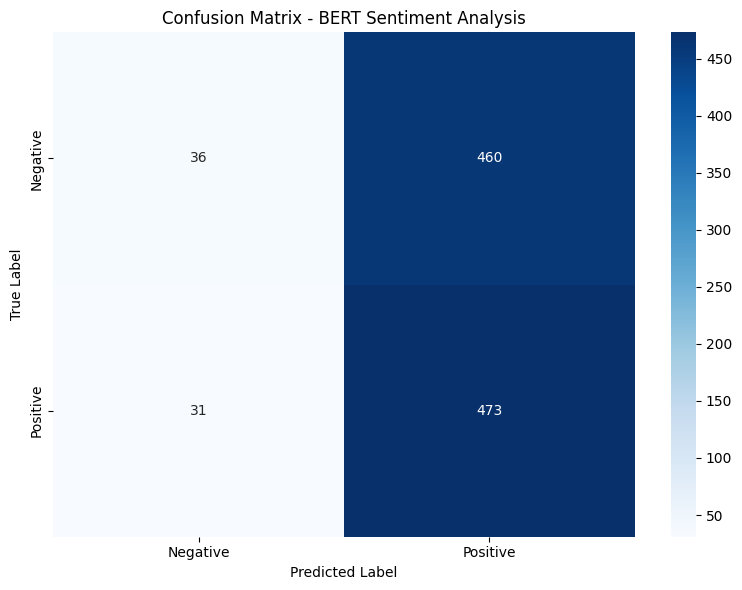


Confusion Matrix (Percentages):
True\Predicted  Negative  Positive
Negative         7.3%     92.7%
Positive         6.2%     93.8%


In [15]:
# Create confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - BERT Sentiment Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Calculate confusion matrix percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
print("True\\Predicted  Negative  Positive")
for i, class_name in enumerate(class_names):
    print(f"{class_name:8}      {cm_percent[i][0]:6.1f}%   {cm_percent[i][1]:6.1f}%")


In [16]:
# Function to predict sentiment for new reviews
def predict_sentiment(text, model, tokenizer, device, max_length=256):
    model.eval()
    
    # Tokenize the input text
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()
    
    sentiment = 'Positive' if predicted_class == 1 else 'Negative'
    return sentiment, confidence

# Sample reviews for testing
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.",
    "I was completely disappointed with this film. The story was boring and the characters were poorly developed.",
    "An average movie with some good moments but nothing spectacular. Worth watching once.",
    "Outstanding cinematography and brilliant performances make this a must-watch film.",
    "Terrible acting and a confusing plot made this movie unwatchable."
]

print("Sentiment Predictions on Sample Reviews:")
print("=" * 60)

for i, review in enumerate(sample_reviews, 1):
    sentiment, confidence = predict_sentiment(review, model, tokenizer, device)
    print(f"\n{i}. Review: {review[:80]}...")
    print(f"   Predicted Sentiment: {sentiment}")
    print(f"   Confidence: {confidence:.4f}")


Sentiment Predictions on Sample Reviews:

1. Review: This movie was absolutely fantastic! The acting was superb and the plot was enga...
   Predicted Sentiment: Positive
   Confidence: 0.5732

2. Review: I was completely disappointed with this film. The story was boring and the chara...
   Predicted Sentiment: Positive
   Confidence: 0.5647

3. Review: An average movie with some good moments but nothing spectacular. Worth watching ...
   Predicted Sentiment: Positive
   Confidence: 0.5537

4. Review: Outstanding cinematography and brilliant performances make this a must-watch fil...
   Predicted Sentiment: Positive
   Confidence: 0.5037

5. Review: Terrible acting and a confusing plot made this movie unwatchable....
   Predicted Sentiment: Positive
   Confidence: 0.5413


In [18]:
# Final summary statistics
print("BERT Sentiment Analysis - Final Summary")
print("=" * 50)
print(f"Dataset: IMDB Movie Reviews ({SAMPLE_SIZE:,} samples)")
print(f"Model: BERT-base-uncased")
print(f"Training samples: {len(train_texts):,}")
print(f"Test samples: {len(test_texts):,}")
print(f"\nFinal Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_avg:.4f}")
print(f"Recall: {recall_avg:.4f}")
print(f"F1-Score: {f1_avg:.4f}")



BERT Sentiment Analysis - Final Summary
Dataset: IMDB Movie Reviews (5,000 samples)
Model: BERT-base-uncased
Training samples: 4,000
Test samples: 1,000

Final Model Performance:
Accuracy: 0.5090
Precision: 0.5220
Recall: 0.5090
F1-Score: 0.3952
